In [2]:
import keras
import nltk
import pandas
import numpy as np
import re
import codecs

Using TensorFlow backend.


In [3]:
# Sanitizing input

In [7]:
input_file = codecs.open("socialmedia_relevant_cols.csv", "r", encoding=u'utf-8', errors=u'replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)        

In [11]:
# inspect the data
import pandas as pd
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.columns=[u'text', u'choose_one', u'class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [12]:
questions.tail()

,text,choose_one,class_label
10809,The twins pitcher's ego is now WRECKED,Not Relevant,0
10810,@Tunes_WGG lol. U got wrecked,Not Relevant,0
10811,you wrecked my whole world,Not Relevant,0
10812,I wrecked my stomach help,Not Relevant,0
10813,@__ohhmyjoshh @stevenrulles he not gonna be th...,Not Relevant,0


In [13]:
questions.describe()

,class_label
count,10814.000000
mean,0.431570
std,0.498297
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [15]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", "")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")
questions.to_csv("clean_data.csv")
questions.head()

,text,choose_one,class_label
0,justhappenedaterriblecarcrash,Relevant,1
1,ourdeedsarethereasonofthisearthquakemayallahfo...,Relevant,1
2,"heardaboutearthquakeisdifferentcities,staysafe...",Relevant,1
3,"thereisaforestfireatspotpond,geesearefleeingac...",Relevant,1
4,forestfirenearlarongesaskcanada,Relevant,1


In [16]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10809,10809,thetwinspitcher'segoisnowwrecked,Not Relevant,0
10810,10810,lolugotwrecked,Not Relevant,0
10811,10811,youwreckedmywholeworld,Not Relevant,0
10812,10812,iwreckedmystomachhelp,Not Relevant,0
10813,10813,henotgonnabethinkingthatwhenhegetshisshitwreck...,Not Relevant,0


In [17]:
clean_questions.groupby("class_label").count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6163,6163,6163
1,4635,4635,4635
2,16,16,16


In [18]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,justhappenedaterriblecarcrash,Relevant,1,[justhappenedaterriblecarcrash]
1,1,ourdeedsarethereasonofthisearthquakemayallahfo...,Relevant,1,[ourdeedsarethereasonofthisearthquakemayallahf...
2,2,"heardaboutearthquakeisdifferentcities,staysafe...",Relevant,1,"[heardaboutearthquakeisdifferentcities, staysa..."
3,3,"thereisaforestfireatspotpond,geesearefleeingac...",Relevant,1,"[thereisaforestfireatspotpond, geesearefleeing..."
4,4,forestfirenearlarongesaskcanada,Relevant,1,[forestfirenearlarongesaskcanada]


In [19]:
# Inspecting our dataset a little more
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print ("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print ("Max sentence length is %s" % max(sentence_lengths))

17657 words total, with a vocabulary size of 14371
Max sentence length is 12


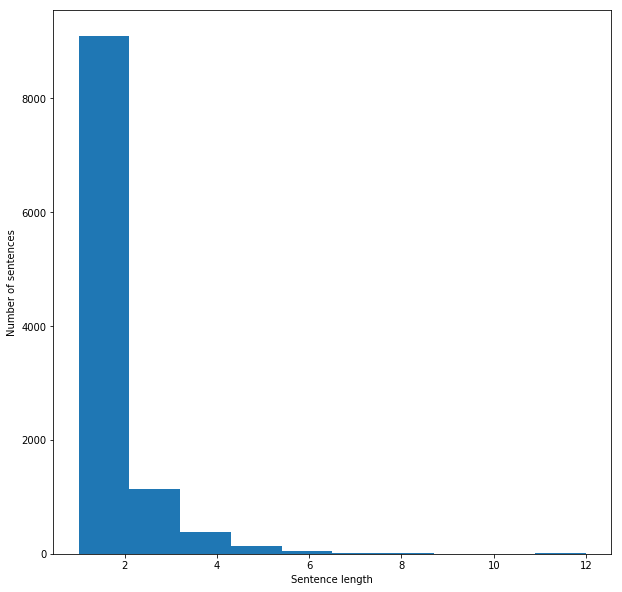

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.xlabel(u'Sentence length')
plt.ylabel(u'Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [25]:
# Bag of Words Counts

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

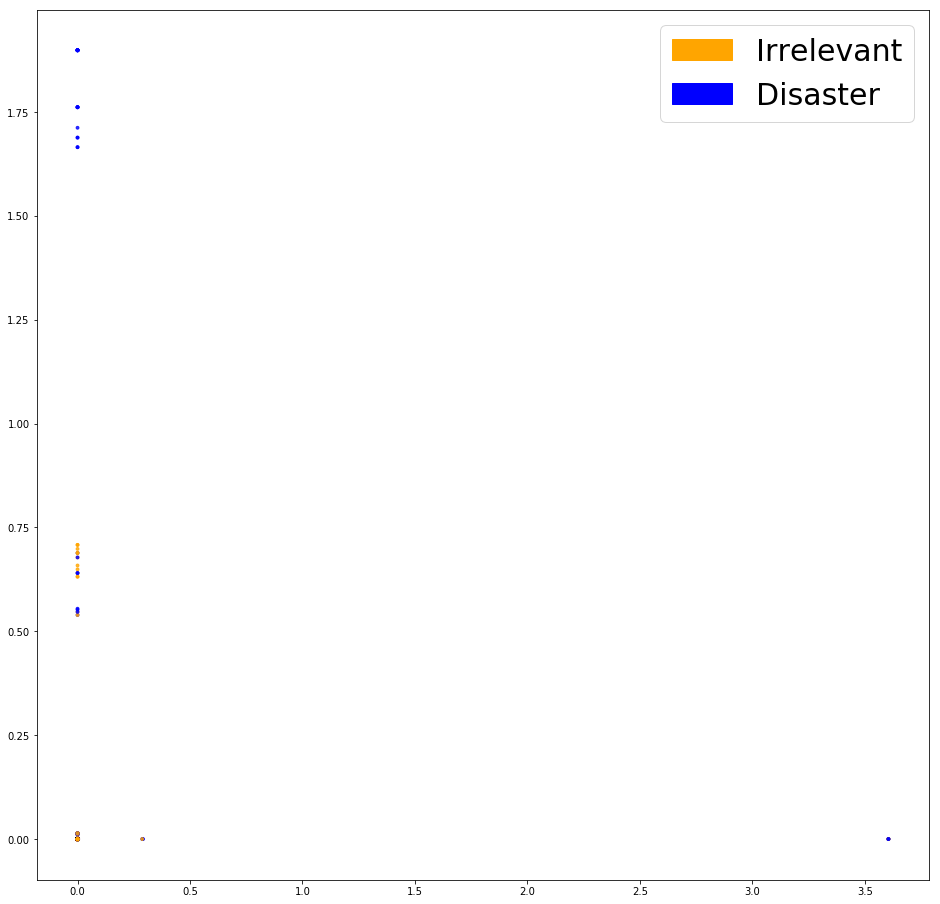

In [29]:
# Visualizing the embeddings

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [31]:
# Fitting a classifier
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight=u'balanced', solver=u'newton-cg', multi_class=u'multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

In [32]:
# Evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):
    precision = precision_score(y_test, y_predicted, pos_label=None, average=u'weighted')
    recall = recall_score(y_test, y_predicted, pos_label=None, average=u'weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average=u'weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.628, precision = 0.694, recall = 0.628, f1 = 0.560


In [34]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

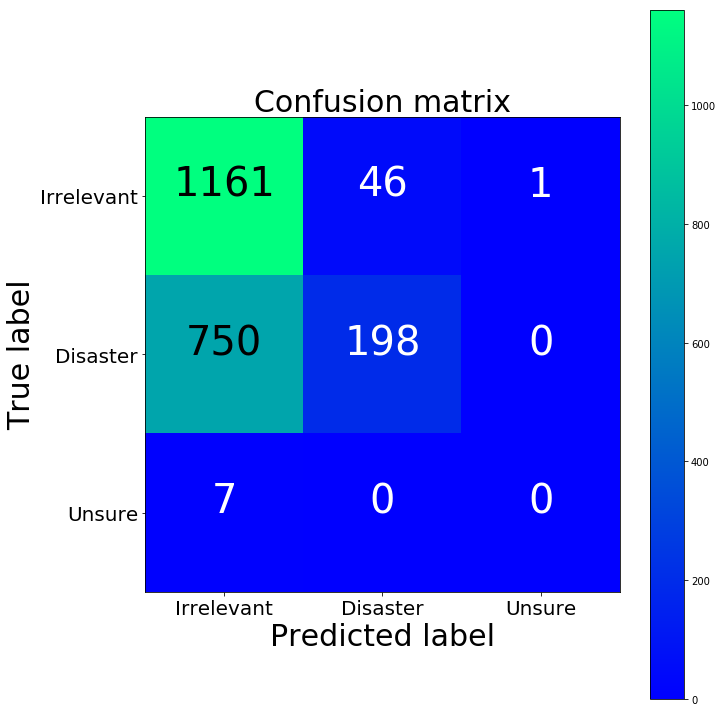

[[1161   46    1]
 [ 750  198    0]
 [   7    0    0]]


In [35]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=[u'Irrelevant', u'Disaster', u'Unsure'], normalize=False, title=u'Confusion matrix')
plt.show()
print (cm)

In [38]:
# Further inspection

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k, v in vectorizer.vocabulary_.items()}
    
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key=lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key= lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {u'tops':tops, u'bottom':bottom}
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

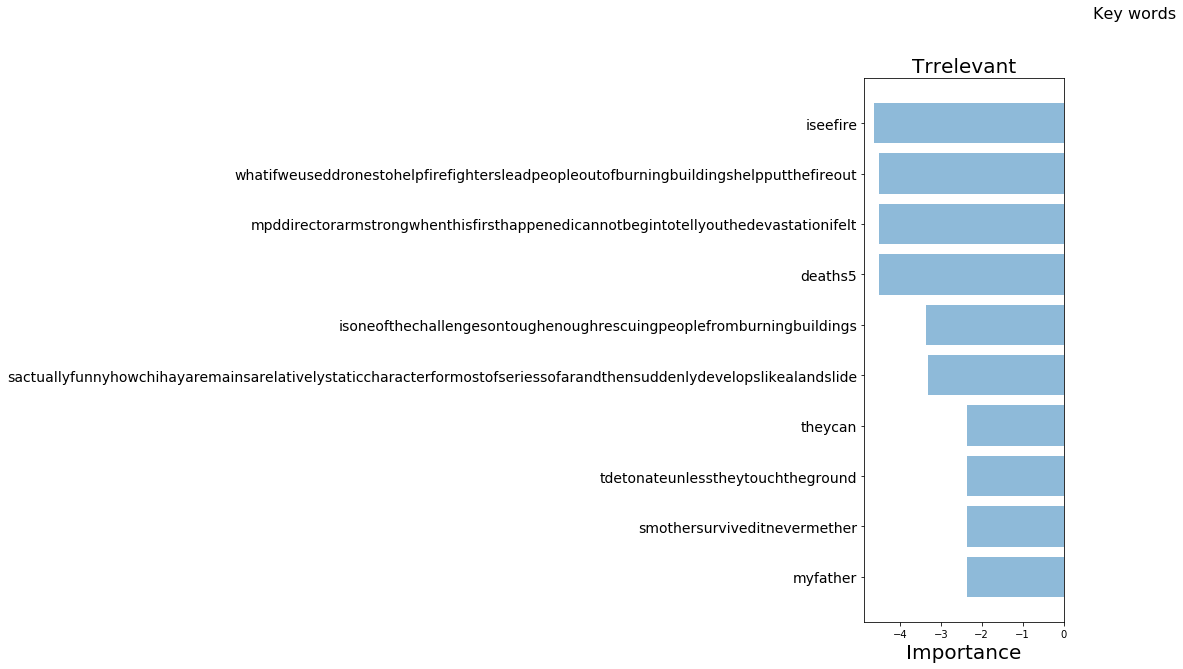

In [43]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a, b) for a, b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key= lambda x: x[1])
    
    bottom_pairs = [(a, b) for a, b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))
    
    plt.subplot(121)
    plt.barh(y_pos, bottom_scores, align=u'center', alpha=0.5)
    plt.title(u'Trrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle("Key words", fontsize=16)
    plt.xlabel(u'Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    
top_scores = [a[0] for a in importance[1][u'tops']]
top_words = [a[1] for a in importance[1][u'tops']]
bottom_scores = [a[0] for a in importance[1][u'bottom']]
bottom_words = [a[1] for a in importance[1][u'bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [44]:
# TFIDF Bag of Words

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train =tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

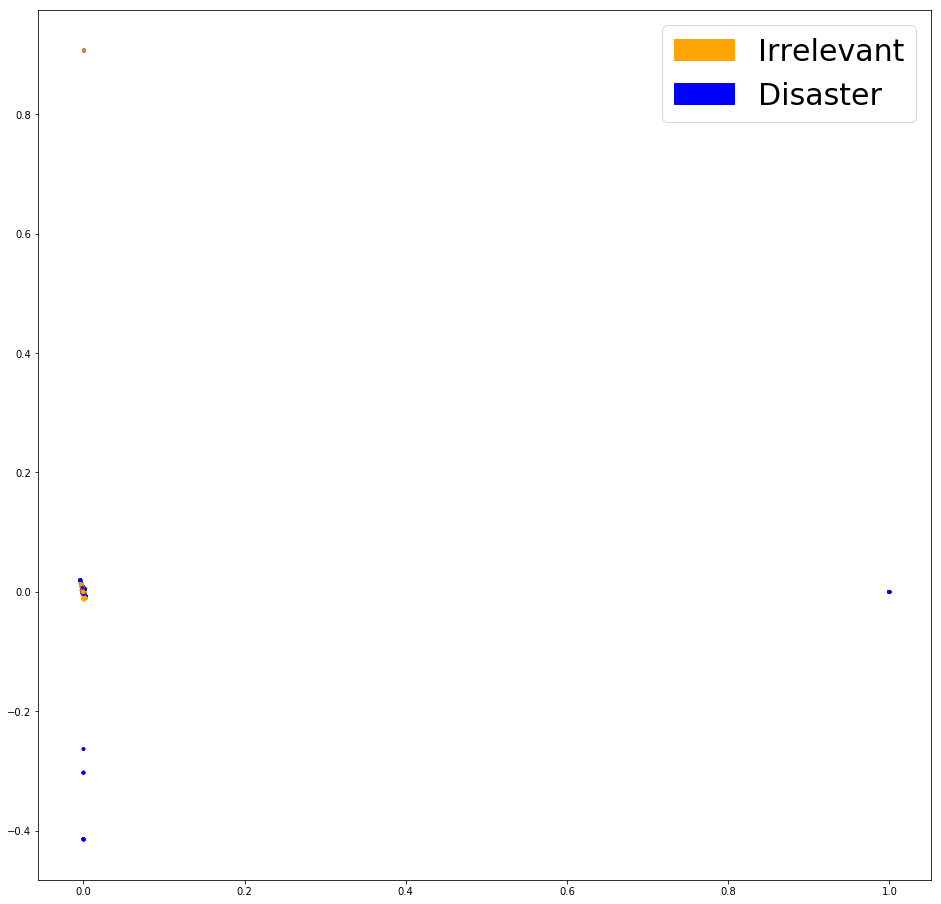

In [45]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [46]:
clf_tfidf = LogisticRegression(C=30.0, class_weight=u'balanced', solver=u'newton-cg', multi_class=u'multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [47]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accurancy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf))

accurancy = 0.628, precision = 0.692, recall = 0.628, f1 = 0.561


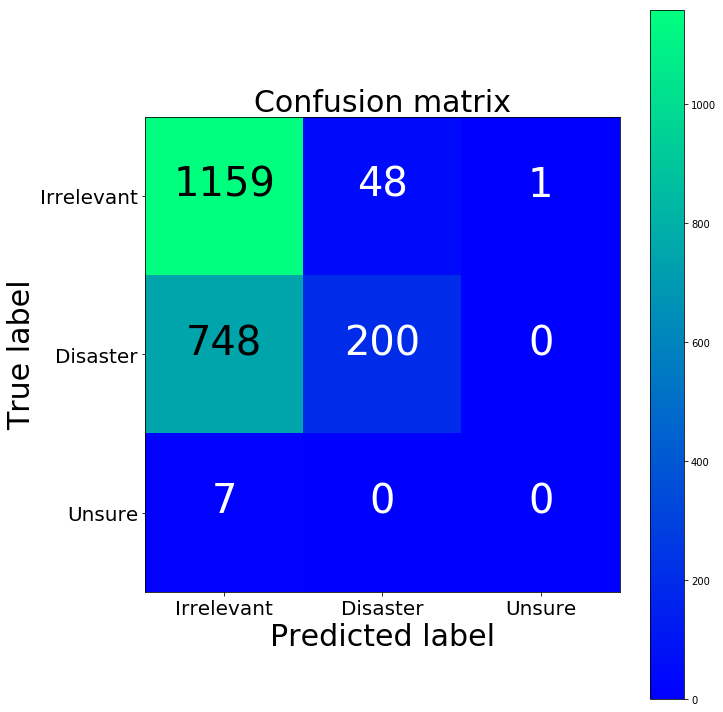

TFIDF confusion matrix
[[1159   48    1]
 [ 748  200    0]
 [   7    0    0]]
BoW confusion matrix
[[1161   46    1]
 [ 750  198    0]
 [   7    0    0]]


In [48]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=[u'Irrelevant', u'Disaster', u'Unsure'], normalize=False, title=u'Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [49]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

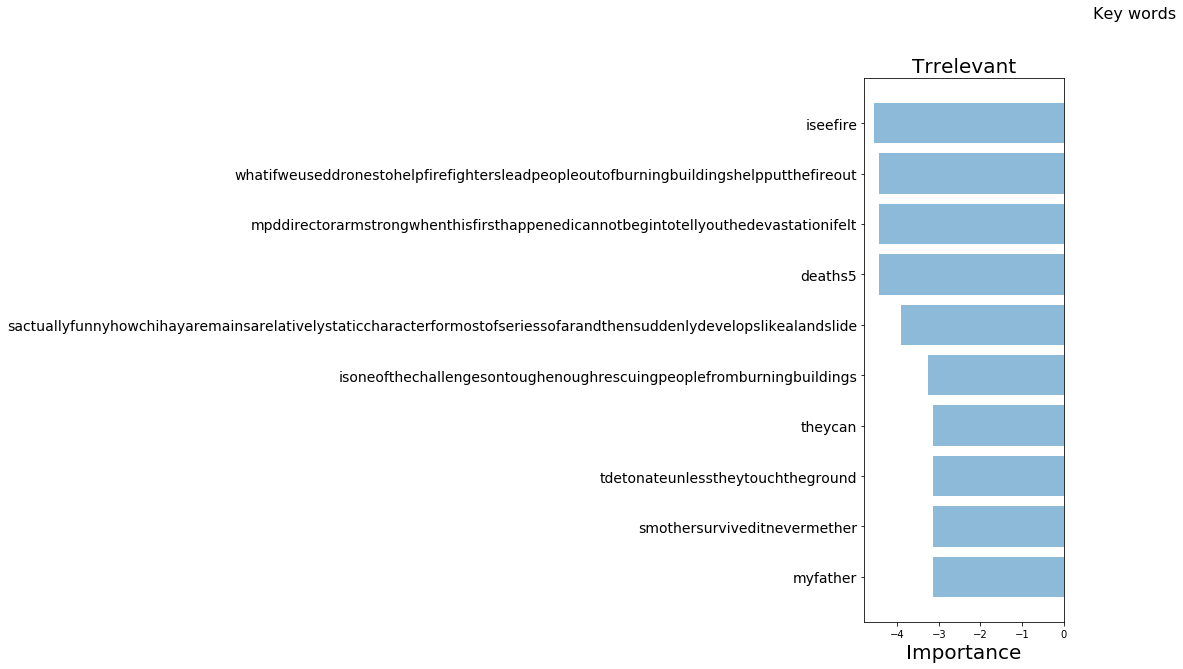

In [50]:
top_scores = [a[0] for a in importance_tfidf[1][u'tops']]
top_words = [a[1] for a in importance_tfidf[1][u'tops']]
bottom_scores = [a[0] for a in importance_tfidf[1][u'bottom']]
bottom_words = [a[1] for a in importance_tfidf[1][u'bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [ ]:
# Enter word2vec
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [56]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions[u'tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, test_size=0.2, random_state=40)

In [ ]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(embeddings, list_labels)
plt.show()

In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [62]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [63]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [ ]:
visualize_one_exp(X_test_data, y_test_data, 65)

In [ ]:
visualize_one_exp(X_test_data, y_test_data, 60)

In [ ]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

In [ ]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [ ]:
# CNNs for text classification

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["text"].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(clean_questions["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

In [ ]:
# efine a simple Convolutional Neural Network

from keras.layers import Dense, Input, Flatten, Dropout, Merge
from keras.layers import Conv1D, MaxPool1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model    

In [ ]:
# train Neural Network
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(clean_questions["class_label"].unique())), False)

In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

In [ ]:
# Yelp review generation

# code from https://github.com/ajmanser/Yelp

from keras import layers
import sys

# Dictionary mapping unique characters to their index in `chars`
text=open('seed_text.txt').read()
chars=['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']

char_indices = dict((char, chars.index(char)) for char in chars)
maxlen=60
step=1

model = keras.models.Sequential()
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.load_weights("pretrained-yelp.hdf5")

optimizer = keras.optimizers.Adam(lr=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def random_reviews():
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('Coming up with several reviews for you...')

    for temperature in [0.8]:
        sys.stdout.write(generated_text)

        # We generate 600 characters
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print(generated_text)

In [ ]:
random_reviews()

In [ ]:
# Making Deep Learning models better
from nltk.corpus import wordnet as wn

def food_related(nouns):

    food=wn.synset('food.n.01')
    final_list=[]
    for word in nouns:
        temp=word
        word=word+'.n.01'
        try:
            if food.wup_similarity(wn.synset(word))>0.20 and temp!='food':
                final_list.append(temp)
        except:
            pass

    return final_list

def user_custom(foods):
    # enter foods as a string separated by commas. For example 'sushi, sashimi, maki'
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('Coming up with two ideas for you...')

    final=generated_text+''

    for temperature in [0.8]:


        # We generate 600 characters
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            final+=next_char

            generated_text += next_char
            generated_text = generated_text[1:]
    
    #print first review, then second via SOR/EOR
    temp=personalized_clean_up(final, foods)
    start=temp.find('SOR')
    stop=findStrAfterStr(temp, 'EOR', 'SOR')
    end_first=temp[start+4:stop]

    new=temp[get_second_index(temp, 'SOR')+4:]
    ending=new.find('EOR')
    print(temp[start+4:stop])
    print("")
    print(new[:ending])
    
def personalized_clean_up(review,user_items):
    #take generic review, and replace with user generated words
    generic_nouns=review_to_nouns(review)
    food_generic=food_related(generic_nouns)

    user_picked_items=user_items.split(",")

    final=[]
    for word in re.findall(r"[\w']+|[.,!?;]", review):
        if word in food_generic and len(user_picked_items)>1:
            word=np.random.choice(user_picked_items)
            final.append(word)
            else:
            final.append(word)

    new_review=" ".join(final)
    return re.sub(r'\s+([?.!",])', r'\1', new_review)

def review_to_nouns(review):
    is_noun = lambda pos: pos[:2] == 'NN'
    token=nltk.word_tokenize(review)
    nouns=[word for (word, pos) in nltk.pos_tag(token) if is_noun(pos)]
    return nouns

def findStrAfterStr(myString, searchText, afterText):
    after_index = myString.index(afterText)
    return myString.find(searchText, after_index)

def get_second_index(input_string, sub_string):
    return input_string.index(sub_string, input_string.index(sub_string) + 1)

In [ ]:
user_custom('burrito, taco, guac')